## Small Dataset Full-Image Species Exploration 

In this notebook, we explore a small portion of Haiti Tree Project (THTP) captures labeled by Cam. These are full images and represent a small portion of the dataset (hence small). This notebook is for transfer learning using a pretrained Inception v3 classifier, same as that used by Pl@ntNet.


### Dependencies

In [1]:
import torch
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import urllib
import time

from PIL import Image

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import torchvision.models as models
from torchvision.io import read_image
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader


import requests
import json
import datetime 
import logging 




torch.backends.cudnn.benchmark = True

### Data Retrieval
 
 
For now, download each image/label pair Cam has specified ([Github link](https://gconfusion_matrixcom/Greenstand/Tree_Species/tree/master/training)).

In [2]:
# Directly downloads the dataurl variable (link to Cam's training set) to datadir
datadir = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/training.psv"
dataurl = "https://raw.githubusercontent.com/Greenstand/Tree_Species/master/training/training.psv"
data_update = requests.get(dataurl)
if data_update.status_code == 200:
    print ("Successfully downloaded training set")
    with open(datadir, 'w') as f:
        f.write(data_update.text)
baseurl = "https://treetracker-production-images.s3.eu-central-1.amazonaws.com/"
assert os.path.exists(datadir)
data = pd.read_csv(datadir, sep="|", header=None)
data.columns = ["class", "imname"]
data["url"] = baseurl + data["imname"]
print (data.shape[0], " samples")
data.head(5)

Successfully downloaded training set
2044  samples


,class,imname,url
0,ACACAURI,2020.11.29.12.18.36_18.285143729299307_-73.564...,https://treetracker-production-images.s3.eu-ce...
1,ACACAURI,2020.11.29.12.18.59_18.285102993249893_-73.564...,https://treetracker-production-images.s3.eu-ce...
2,ACACAURI,2020.11.29.12.47.34_18.290133895352483_-73.557...,https://treetracker-production-images.s3.eu-ce...
3,ACACAURI,2020.11.29.12.47.48_18.29019017983228_-73.5579...,https://treetracker-production-images.s3.eu-ce...
4,ACACAURI,2020.11.29.12.48.33_18.29018481541425_-73.5579...,https://treetracker-production-images.s3.eu-ce...


In [3]:
# Save images to local memory if they haven't been already. For this size it's ok, but as the dataset grows we should move this to S3.
# Sometimes images throw errors when being downloaded, need to look into why. 

savepath = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/"
for species in data["class"].unique():
    if not os.path.exists(os.path.join(savepath, species)):
        os.makedirs(os.path.join(savepath, species))
        
def image_saver(df):
    if os.path.exists(os.path.join(savepath, df["class"], df["imname"])):
        img = Image.open(os.path.join(savepath, df["class"], df["imname"])) # open the image file
        if img.verify(): 
            return True     
    try:
        urllib.request.urlretrieve(df["url"], os.path.join(savepath, df["class"], df["imname"]))
        return True
    except:
        return False
    
        
data["saved"] = data.apply(image_saver, axis=1)
print (data[data["saved"]].shape[0], " images saved out of ", data.shape[0]) 

1976  images saved out of  2044


1976  total valid samples
Class breakdown
{'ACACAURI': 217, 'ANACOCCI': 125, 'CATALONG': 201, 'CEDRODOR': 318, 'DOMBTORR': 64, 'GREVROBU': 71, 'MANGINDI': 794, 'SENNSIAM': 60, 'SIMAGLAU': 126}
9  classes found


Text(0.5, 1.0, 'Count per class')

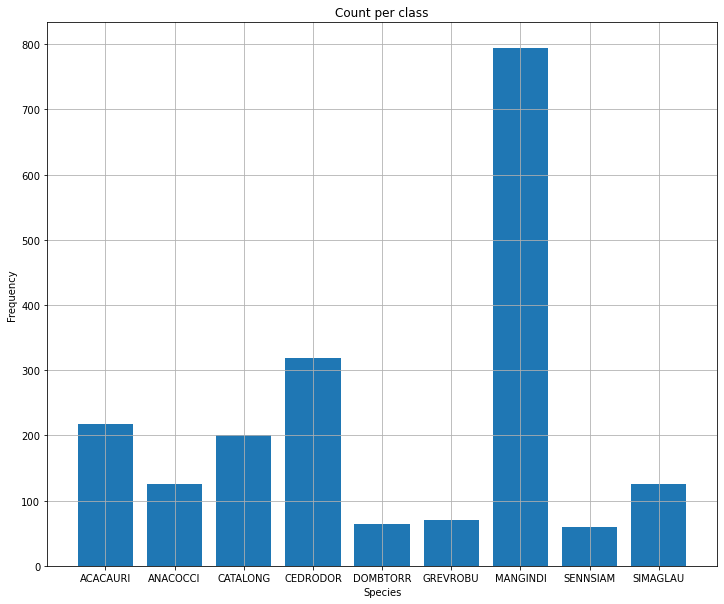

In [4]:
# Quick look at species distribution
data = data[data["saved"]]
print (data.shape[0], " total valid samples")
print ("Class breakdown")
count_by_class = data.groupby("class").aggregate("count")
baseline_acc = np.max
print (dict(zip(count_by_class.index, count_by_class.values[:, 0])))
num_classes = data["class"].unique().shape[0]
print (num_classes, " classes found")
plt.figure(figsize=(12, 10))
plt.bar(count_by_class.index, count_by_class["imname"])
plt.grid()
plt.xlabel("Species")
plt.ylabel("Frequency")
plt.title("Count per class")

In [5]:
arrs = []
labels = []
# You must initialize logging, otherwise you'll not see debug output.
logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

for species in data["class"].unique():
    for img in os.listdir(os.path.join(savepath, species)):
        if os.path.splitext(os.path.join(savepath, species, img))[1].lower() in [".jpg", ".png"]:
            arrs.append(Image.open(os.path.join(savepath, species, img)).resize((299, 299)))
            labels.append(species)
            


## Visualize a few images, explore features



In [1]:
%pylab inline

# Tried to use PCA and t-SNE to get a sense of complexity. 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import feature
from skimage.color import rgb2gray
from skimage.filters import * 
import cv2 

n_imgs = 9
idxs = np.random.choice(np.arange(0, len(arrs)), replace=False, size=n_imgs)
f, axarr = plt.subplots(int(np.sqrt(n_imgs)), int(np.sqrt(n_imgs)), figsize=(10 ,10))


params = cv2.SimpleBlobDetector_Params()

params.filterByArea = True
params.minArea = 600
params.maxArea = 10000

params.filterByCircularity = False
params.minCircularity = 0.1
params.maxCircularity =0.6

params.filterByConvexity = True
params.minConvexity = 0.0
params.maxConvexity=0.6

params.filterByInertia = True
params.minInertiaRatio = 0.2
params.maxInertiaRatio=0.9

detector = cv2.SimpleBlobDetector_create(params)

preprocessing = lambda img: gaussian(feature.canny(rgb2gray(np.array(img)), sigma=1), 3)
# preprocessing = lambda img: gabor(rgb2gray(np.array(img)), frequency=3, theta=90)[0]
preprocess = []
for i in range(int(np.sqrt(n_imgs))):
    for j in range(int(np.sqrt(n_imgs))):
        idx = idxs[i * int(np.sqrt(n_imgs)) + j]
        img = np.array(arrs[idx])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # axarr[i, j].imshow(feature.canny(rgb2gray(np.array(arrs[idx]))))
        keypoints = detector.detect(gray)
        img_to_show = cv2.drawKeypoints(gray, keypoints, np.zeros((1,1)), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        axarr[i, j].imshow(img_to_show, cmap='gray')
        axarr[i, j].set_title(labels[idx])
plt.show()
    

Populating the interactive namespace from numpy and matplotlib


NameError: name 'arrs' is not defined

In [ ]:
X = np.vstack([preprocessing(img).flatten() for img in arrs])
pca = PCA(n_components=50)
X_red = pca.fit_transform(X)
print('Explained variance per principal component: {}'.format(pca.explained_variance_ratio_ * 100))
print (np.sum(pca.explained_variance_ratio_) * 100 , "% variance explained total")

In [ ]:
X_embedded = TSNE(n_components=2, perplexity=80.0, learning_rate=24.0, n_iter=10000).fit_transform(X_red)
tsne_result = pd.DataFrame(X_embedded)
tsne_result["class"] = labels
tsne_result.columns = ["x0", "x1", "class"]
colors = np.linspace(0, 1, len(data["class"].unique()))
colordict = dict(zip(data["class"].unique(), colors))  
tsne_result["Color"] = tsne_result["class"].apply(lambda x: colordict[x])

In [ ]:
print (tsne_result.head(5))

In [ ]:
plt.grid()
plt.scatter(tsne_result["x0"], tsne_result["x1"], c=tsne_result["Color"], label=tsne_result["class"])


## Prepare dataset for training

In [6]:
class HaitiDataset(torch.utils.data.Dataset):
    def __init__(self, df, loadpath, transform, encoding):
        '''
        A dataset with image names, classes, and a provided loading path to load images from
        '''
        self.loadpath = loadpath
        self.data = df
        self.n_classes = self.data["class"].unique().shape[0]
        self.transform = transform
        self.numerical_encoding = dict(zip(sorted(list(self.data["class"].unique())), list(range(self.n_classes))))
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.loadpath, self.data.iloc[idx, :]["class"], self.data.iloc[idx, :]["imname"])
        label = self.data.iloc[idx, :]["class"]
        img = self.transform(Image.open(img_path))
        label = self.numerical_encoding[label]
        return img, label
        
    def make_class_weighting(self, fn=None):
        if fn is None:
            fn = lambda x: x # identity if no further 
        count_by_class = data.groupby("class").aggregate("count") 
        count_by_class = count_by_class / count_by_class.sum()
        count_by_class.index = count_by_class.index.map(self.numerical_encoding)
        return 1/fn(count_by_class.values[:, 0]) #invert to create larger penalty coefficiencts for smaller frequencies


## Initialize Datasets, Augmentation, and Validation

In [7]:
# A random, static validation for now. This should be changed to be a randomized cross-validation at some point.

val_split = 0.2
idxs = np.arange(data.shape[0])
np.random.shuffle(idxs)



tr_idxs = idxs[int (val_split * data.shape[0]):, ...]
val_idxs = idxs[:int (val_split * data.shape[0]), ...]

aug_transform = T.Compose([T.Resize(299), 
                       T.CenterCrop(299), # need center 299 pixel for Inception v3 feature extractor
                       T.RandomVerticalFlip(p=0.5),
                       T.RandomHorizontalFlip(p=0.5), 
                       T.ColorJitter(contrast=0.2, brightness=0.4, hue=0.1, saturation=0.1), 
                       T.ToTensor(),
                       T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                      ])
val_transform  = T.Compose([T.Resize(299), 
                       T.CenterCrop(299), # need center 299 pixel for Inception v3 feature extractor
                       T.ToTensor(),
                       T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                      ])


tr_dataset = HaitiDataset(data.iloc[tr_idxs, :], savepath, aug_transform, None)
val_dataset = HaitiDataset(data.iloc[val_idxs, :], savepath, val_transform, None)

assert tr_dataset.data.shape[0] == len(tr_idxs)
assert val_dataset.data.shape[0] == len(val_idxs)

tr_dataloader = DataLoader(tr_dataset, batch_size=128, shuffle=True, num_workers=1, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=False)


print ("Training size: ", len(tr_idxs))
print ("Validation size: ", len(val_idxs))

Training size:  1581
Validation size:  395


In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def predictor_helper(df, model, preprocess):
    path =  os.path.join(savepath, df["class"], df["imname"])
    img = Image.open(path)
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    model.eval()
    with torch.no_grad():
        output = model(input_batch)
    return output.squeeze().numpy()

In [9]:
def feature_tsne(data, fv_col, pca_ndims=100):
    model_stack = np.vstack([fv for fv in data[fv_col].values])
    pca = PCA(n_components=pca_ndims)
    X_red = pca.fit_transform(model_stack)
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_ * 100))
    print (np.sum(pca.explained_variance_ratio_) * 100 , "% variance explained total")
    model_embedding = TSNE(n_components=2, perplexity=80.0, learning_rate=20.0, n_iter=15000).fit_transform(X_red)
    tsne_model_result = pd.DataFrame(model_embedding)
    tsne_model_result["class"] = data["class"]
    tsne_model_result.columns = ["x0", "x1", "class"]

    # Make figure
    f = plt.figure(figsize=(20, 10))
    scatter = plt.scatter(tsne_model_result["x0"], tsne_model_result["x1"], c=tsne_model_result["class"].astype('category').cat.codes)
    plt.title("t-SNE of %d Haiti Species %s"%(num_classes, fv_col))
    plt.grid()
    plt.legend(handles=scatter.legend_elements()[0],
               labels=list(tsne_model_result["class"].astype('category').cat.categories),
               title="species",
               bbox_to_anchor=(1.2,0.75),
               loc='right')
    plt.show()

In [10]:
def train_model(model, criterion, tr_dataloader, val_dataloader, model_savepath,num_epochs=100, report_interval=1):
    torch.cuda.empty_cache()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        start = time.time()
        tr_acc_sum = 0
        tr_samples = 0
        n_tr_batches = 0
        for batch_x, batch_y in tr_dataloader:
            n_tr_batches += 1
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            optimizer.zero_grad()
            output = model.forward(batch_x)
            if hasattr(output, "logits"):
                loss = criterion(output.logits, batch_y)
                tr_acc_sum += float(torch.sum(torch.argmax(output.logits, dim=1) == batch_y))
            else:
                loss = float(criterion(output, batch_y))
                tr_acc_sum += float(torch.sum(torch.argmax(output, dim=1) == batch_y))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            tr_samples += batch_y.size()[0]
        cf_matx = None
        with torch.no_grad():
            n_val_batches = 0
            val_samples = 0
            running_val_loss = 0
            val_acc_sum = 0
            val_preds = []
            val_labels = []
            for val_x, val_y in val_dataloader:
                n_val_batches += 1
                val_x = val_x.to(device)
                val_y = val_y.to(device)
                val_output = model.forward(val_x)
                if hasattr(val_output, "logits"):
                    val_loss = criterion(val_output.logits, val_y)
                    preds = torch.argmax(val_output.logits, dim=1)
                else:
                    val_loss = criterion(val_output, val_y)
                    preds = torch.argmax(val_output, dim=1)
                running_val_loss += float(val_loss.item())
                val_acc_sum += float(torch.sum(preds == val_y)) # wrote this way just in case there's batched validation
                val_preds.extend([*(preds.detach().cpu().numpy())])
                val_labels.extend([*(val_y.detach().cpu().numpy())])
                val_samples += float(val_y.size()[0])
            cf_matx = confusion_matrix(val_labels, val_preds)
            assert np.sum(cf_matx) == val_samples
            assert len(val_preds) == len(val_labels)
            assert val_samples == len(val_preds)
        if epoch % report_interval == 0:
            print ("Epoch %d finished in %f seconds"%(epoch + 1, time.time() - start))
            print ("Training/Validation Loss per Batch: %f/ %f"%(running_loss / n_tr_batches, running_val_loss / n_val_batches))
            print ("Training/Validation Accuracy (percent): %f /%f"%(100 * tr_acc_sum / tr_samples, 100 * val_acc_sum / val_samples))
            print ("Confusion matrix (true rows\predicted cols):")
            print (cf_matx)
            print ("=" * 40)
    torch.save(model.state_dict(), model_savepath)
    print ("Finished training")
    return model

In [11]:
inception = models.inception_v3(pretrained=True)
set_parameter_requires_grad(inception, feature_extracting=True)

inception_ft_preprocess = T.Compose([
    T.Resize(299),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# This creates a feature-vector pre-output and saves it to a DataFrame, which is helpful for seeing what t-SNE looks like after the
# dataset has been through Inception feature space. 
# data['inception_fv'] = data.apply(predictor_helper, axis=1, model=inception, preprocess=inception_ft_preprocess)
# feature_tsne(data, 'inception_fv', 100)
num_ftrs = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = torch.nn.Linear(num_ftrs, num_classes)



Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [18]:
# Determine trainable parameters and initialize loss and optimization 
# Handle the primary net
num_ftrs = inception.fc.in_features
inception.fc = torch.nn.Linear(num_ftrs,num_classes)

params_to_update = []
for name, param in inception.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("Device: ", device)
print (params_to_update)
class_weights = tr_dataset.make_class_weighting(fn=None) # doesn't need to be normalized, trying out different things
print ("Training class weights: ", class_weights)
criterion = torch.nn.CrossEntropyLoss(reduction="mean", weight=torch.FloatTensor(class_weights).cuda()) #  weight=torch.FloatTensor(class_weights).cuda() if you want to weight
inception = inception.to(device)
inception.train()
optimizer = torch.optim.Adam(params_to_update, lr=5e-4, weight_decay=1e-2)

Device:  cuda:0
[Parameter containing:
tensor([[-0.0097,  0.0352, -0.0217,  ..., -0.0222, -0.0139, -0.0222],
        [-0.0307, -0.0294,  0.0275,  ...,  0.0273,  0.0076, -0.0259],
        [-0.0139, -0.0284,  0.0110,  ...,  0.0343,  0.0239, -0.0337],
        ...,
        [ 0.0053, -0.0345, -0.0060,  ...,  0.0094,  0.0261,  0.0014],
        [ 0.0172, -0.0163,  0.0360,  ...,  0.0256, -0.0359,  0.0008],
        [ 0.0203,  0.0295, -0.0263,  ..., -0.0165,  0.0224,  0.0093]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 0.0124,  0.0113,  0.0130,  0.0259, -0.0064,  0.0309,  0.0279,  0.0317,
        -0.0281], device='cuda:0', requires_grad=True), Parameter containing:
tensor([[-0.0204,  0.0030,  0.0072,  ..., -0.0081, -0.0053,  0.0111],
        [-0.0039, -0.0217,  0.0039,  ..., -0.0143,  0.0018,  0.0162],
        [-0.0216,  0.0094,  0.0015,  ..., -0.0119, -0.0116, -0.0213],
        ...,
        [-0.0101, -0.0150,  0.0142,  ..., -0.0150,  0.0143,  0.0012],
        [

In [19]:
# Training block
torch.cuda.empty_cache() 
model_savepath = os.path.join(str(datetime.datetime.today().date()) + ".pt")
trained_model = train_model(inception, criterion, tr_dataloader, val_dataloader, model_savepath, 30, report_interval=10)


Epoch 1 finished in 65.460890 seconds
Training/Validation Loss per Batch: 2.147398/ 2.058811
Training/Validation Accuracy (percent): 17.773561 /33.417722
Confusion matrix (true rows\predicted cols):
[[20  7  3  9  0  0  7  0  1]
 [ 1  9  1  9  0  0  2  0  3]
 [ 2  6  7 22  1  0  4  3  2]
 [ 7  2  3 37  0  0  4  1  3]
 [ 1  0  2  6  0  2  0  2  1]
 [ 0  1  0  3  1  2  0  4  4]
 [23 13  7 53  0  0 52  4  3]
 [ 1  0  0  2  0  0  1  3  2]
 [ 2  2  0 17  0  0  3  0  2]]
Epoch 11 finished in 65.033606 seconds
Training/Validation Loss per Batch: 1.071137/ 1.152545
Training/Validation Accuracy (percent): 74.067046 /75.696203
Confusion matrix (true rows\predicted cols):
[[ 36   3   0   1   0   0   4   2   1]
 [  0  21   1   2   0   0   0   1   0]
 [  1   2  26   6   3   0   5   0   4]
 [  0   2   0  45   1   0   5   1   3]
 [  0   0   2   1   9   2   0   0   0]
 [  0   0   1   0   0  14   0   0   0]
 [ 15   1   2   5   1   1 128   0   2]
 [  1   0   0   0   0   1   0   7   0]
 [  1   1   1   4 

In [22]:
inception.load_state_dict(torch.load("model_params/2022-04-08.pt"), strict=False)
inception.cuda()
inception.eval()
label_decode = {y:x for x,y in val_dataset.numerical_encoding.items()}
val_imgs = []
preds = []
labels = []

print (label_decode)
for j in range(len(val_dataset)):
    pred = int(torch.argmax(inception.forward(torch.unsqueeze(val_dataset[j][0], 0).cuda())).cpu().numpy())
    label = val_dataset[j][1]
    val_imgs.append(val_dataset[j][0].permute(1, 2, 0))
    preds.append(label_decode[pred])
    labels.append(label_decode[label])
    
    

{0: 'ACACAURI', 1: 'ANACOCCI', 2: 'CATALONG', 3: 'CEDRODOR', 4: 'DOMBTORR', 5: 'GREVROBU', 6: 'MANGINDI', 7: 'SENNSIAM', 8: 'SIMAGLAU'}


In [ ]:
# Image carousel packages to install
# ! conda install -c conda-forge ipympl
# ! conda install nodejs
# ! jupyter labextension install @jupyter-widgets/jupyterlab-manager
# ! conda install ipympl
# !jupyter lab build

In [9]:
# Tried to make a UI for seeing mistakes in the model, not working yet
i = 0
def make_carousel(fig, imgs, labels, preds):
    def img_helper(f, img):
        f.add_subplot(111)
        plt.imshow(img)
    
    def onclick1(fig):
        global i
        print(i)
        fig.clear()
        i += 1
        i %= len(imgs)
        switch_figs[i](fig)
        fig.canvas.draw()
        plt.draw()
        
    lambdas = [lambda f: img_helper(f, img) for img in imgs]
    switch_figs = dict(enumerate(lambdas))
    print (len(lambdas))

    switch_figs[0](fig)
    fig.canvas.callbacks.connect('pick_event', onclick1)    
    plt.show()
make_carousel(plt.figure(), val_imgs, None, None)

ModuleNotFoundError: No module named 'ipympl'

## Resnet


In [ ]:
resnet = models.resnet18(pretrained=True)
resnet_ft_preprocess = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data['resnet_fv'] = data.apply(predictor_helper, axis=1, model=resnet, preprocess=resnet_ft_preprocess)
set_parameter_requires_grad(resnet, feature_extracting=True)
feature_tsne(data, 'resnet_fv', 100)
# resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)


In [26]:
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("Device: ", device)
print (params_to_update)
class_weights = tr_dataset.make_class_weighting()
criterion = torch.nn.CrossEntropyLoss(reduction="mean", weight=torch.Tensor(class_weights)).cuda()
resnet = resnet.to(device)
resnet.train()
optimizer = torch.optim.Adam(params_to_update, lr=1e-3, weight_decay=1e-4)

Device:  cuda:0
[Parameter containing:
tensor([[ 0.0160,  0.0083,  0.0413,  ...,  0.0004, -0.0305,  0.0125],
        [ 0.0006, -0.0131, -0.0082,  ..., -0.0202,  0.0381, -0.0142],
        [-0.0233, -0.0146,  0.0075,  ..., -0.0389, -0.0211,  0.0253],
        [ 0.0310,  0.0157, -0.0223,  ...,  0.0064,  0.0433, -0.0195],
        [-0.0197, -0.0389, -0.0179,  ..., -0.0058,  0.0379,  0.0225],
        [ 0.0081,  0.0378,  0.0400,  ..., -0.0318,  0.0070, -0.0274]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 0.0207,  0.0219,  0.0040,  0.0159,  0.0386, -0.0272], device='cuda:0',
       requires_grad=True)]


In [ ]:
resnet_transform =transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

resnet_tr_dataset = HaitiDataset(data.iloc[tr_idxs, :], savepath, resnet_transform, None)
resnet_val_dataset = HaitiDataset(data.iloc[val_idxs, :], savepath, resnet_transform, None)

resnet_tr_dataloader = DataLoader(resnet_tr_dataset, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)
resnet_val_dataloader = DataLoader(resnet_val_dataset, batch_size=val_idxs.shape[0], shuffle=True, num_workers=1, pin_memory=True)


train_model(resnet, criterion, resnet_tr_dataloader, resnet_val_dataloader, 100)

Explained variation per principal component: [15.950658   10.197018    7.0865097   5.3097863   3.8562565   3.2193384
  2.8675094   2.2569125   1.8866559   1.8763889   1.6282377   1.5313106
  1.3823315   1.3098458   1.216342    1.1202374   1.059854    1.0431799
  0.9635737   0.9369926   0.89467114  0.83501947  0.7251442   0.708446
  0.6928109   0.65130323  0.6312378   0.6060742   0.59815586  0.5535824
  0.52986556  0.5097439   0.49321628  0.47613963  0.45040604  0.43557003
  0.4252381   0.40689647  0.39391917  0.38257545  0.3787797   0.36258066
  0.3605402   0.34350812  0.32725585  0.3214988   0.31331986  0.30985245
  0.29811502  0.29436624  0.28487843  0.2843782   0.27053607  0.26630053
  0.25671053  0.25117275  0.2488056   0.24565318  0.23996744  0.22888267
  0.22580123  0.21963038  0.21352763  0.20788088  0.20358223  0.20263097
  0.1953113   0.1938607   0.18820581  0.18382494  0.17847909  0.17504913
  0.17362493  0.1682798   0.16554777  0.16405502  0.16091852  0.15890558
  0.15724002

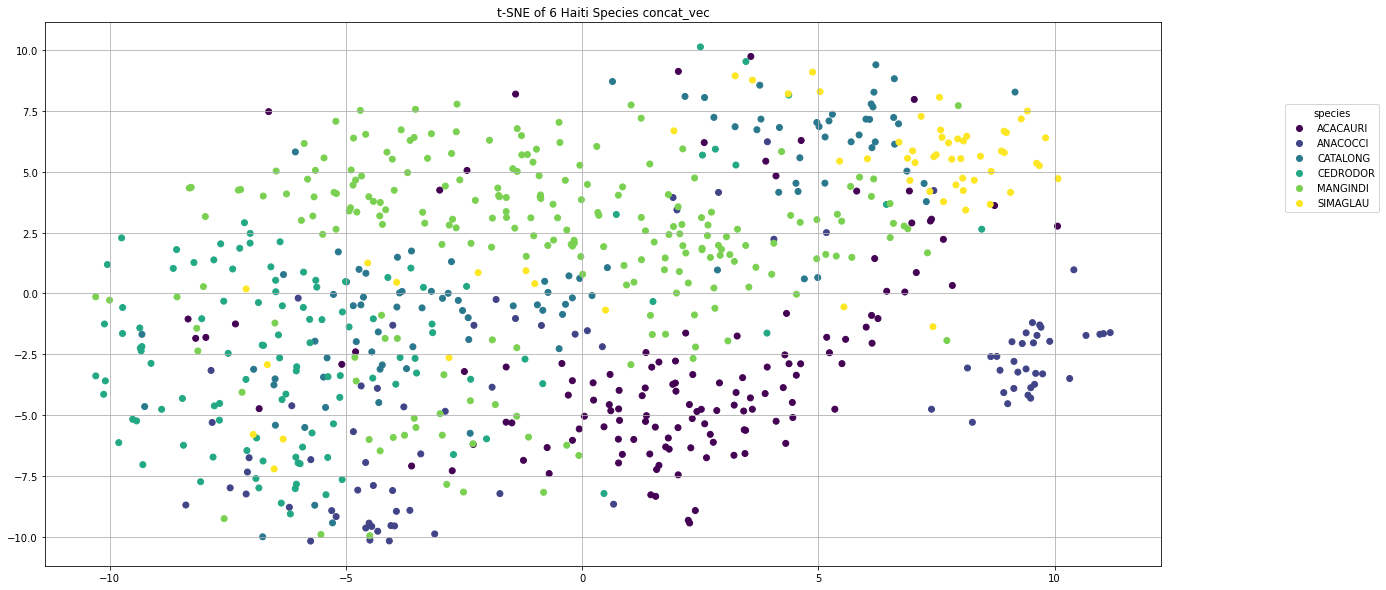

In [83]:
inception_size = data.iloc[0]['inception_fv'].shape
resnet_size = data.iloc[0]['resnet_fv'].shape
concat_vecs = lambda df: np.concatenate([df["inception_fv"], df["resnet_fv"]], axis=None)
data['concat_vec'] = data.apply(concat_vecs, axis=1)
feature_tsne(data, 'concat_vec', 250)

## Trying combined feature vectors 


In [11]:
class VectorDataset(torch.utils.data.Dataset):
    def __init__(self, df, vec_column):
        '''
        A dataset with feature vectors precomputed, classes, and a provided loading path to load images from
        '''
        self.data = df
        self.vec_column = vec_column
        self.n_classes = self.data["class"].unique().shape[0]
        self.numerical_encoding = dict(zip(sorted(list(self.data["class"].unique())), list(range(self.n_classes))))
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        vec = self.data.iloc[idx, :][self.vec_column]
        label = self.data.iloc[idx, :]["class"]
        label = self.numerical_encoding[label]
        return vec, label
        
    def make_class_weighting(self):
        count_by_class = data.groupby("class").aggregate("count") 
        count_by_class = count_by_class / count_by_class.sum()
        count_by_class.index = count_by_class.index.map(self.numerical_encoding)
        return count_by_class.values[:, 0]

linmodel = torch.nn.Sequential(
    torch.nn.Linear(in_features=2000, out_features=2048),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(in_features=2048, out_features=num_classes),
    torch.nn.Softmax()
)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

val_split = 0.3
num_epochs = 100

idxs = np.arange(data.shape[0])
np.random.shuffle(idxs)

tr_idxs = idxs[:int (val_split * data.shape[0]), ...]
val_idxs = idxs[int (val_split * data.shape[0]):, ...]

tr_dataset = VectorDataset(data.iloc[tr_idxs, :], "concat_vec")
val_dataset = VectorDataset(data.iloc[val_idxs, :], "concat_vec")

tr_dataloader = DataLoader(tr_dataset, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_idxs.shape[0], shuffle=True, num_workers=1, pin_memory=True)


class_weights = tr_dataset.make_class_weighting()
criterion = torch.nn.CrossEntropyLoss(reduction="mean", weight=torch.Tensor(class_weights)).cuda()
linmodel = linmodel.to(device)
linmodel.train()

optimizer = torch.optim.Adam(params_to_update, lr=1e-4, weight_decay=1e-4)



NameError: name 'device' is not defined

In [10]:
train_model(linmodel, criterion, tr_dataloader, val_dataloader, 500, report_interval=50)

NameError: name 'train_model' is not defined